In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve,root

b=2.3e-5
M_p=1

x = sp.symbols('x')

def potencial(x,kappa,lambda_0,xi):

    return (lambda_0+b*sp.log(sp.tanh(sp.sqrt(xi)*x)/kappa)**2)*sp.tanh(sp.sqrt(xi)*x)**4/4/xi**2


def fit_phi_0_try(phi_0,kappa,xi,lambda_0):
    
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    V_0=potencial(phi_0[0],kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0[0]}) 
    #print("Nueva iteración para phi_0: ",1-((M_p*Vd_0/V_0)**2).evalf()/2, phi_0[0])
    
    return 1-((M_p*Vd_0/V_0)**2)/2

def correct_phi_0_try(kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
    
    #x_0=0.005 #parámetro inicial de iteración
    x_0=np.arcsinh(np.sqrt(32*xi))/(2*np.sqrt(xi)) #parámetro inicial de iteración
    
    phi_0=fsolve(fit_phi_0_try,x_0,args=(kappa,xi,lambda_0))
    
    return phi_0[0]

def evol_phi(phi,N,kappa,lambda_0,xi):
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    V=potencial(phi[0],kappa,lambda_0,xi)
    Vd=derivada_1.evalf(subs={x: phi[0]})
    
    return sp.sqrt((M_p*Vd/V)**2)

def all_parameters(phi_0,kappa,xi,lambda_0):
    
    if phi_0<0:
        phi_0=-phi_0
        
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    
    N=np.linspace(0,60,1000)
    
    #Calculo phi(N)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    plt.plot(N,phi_N)
    plt.title("Campo phi en función de N")
    plt.show()
    
    phi_f=phi_N[-1]
    phi_60=phi_f[0]
    
    V_0=potencial(phi_0,kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0})
    Vdd_0=derivada_2.evalf(subs={x: phi_0})
    
    V_60=potencial(phi_60,kappa,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: phi_60})
    Vdd_60=derivada_2.evalf(subs={x: phi_60})
    
    eps_v_0=((M_p*Vd_0/V_0)**2)/2
    eta_v_0=M_p**2*Vdd_0/V_0
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60)**2)/2
    eta_v_60=M_p**2*Vdd_60/V_60
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    P_r=sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)
    n_s=1-eta_60-2*eps_60
    r=16*eps_60
    
    print("El valor de n_s es ",n_s.evalf())
    print("El valor de r es ", r.evalf())
    print("La normalización de P_r es", P_r.evalf())
    print("El valor de eps(0) es ", eps_0.evalf())
    print("El valor de phi(60) es ",phi_60)
    
    return [eps_0,n_s,r,P_r]

def fit(x_fit,kappa,xi):
    
    lambda_0=x_fit[0]
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    phi_0=correct_phi_0_try(kappa,xi,lambda_0)
        
    if phi_0<0:
        phi_0=-phi_0
    
    #Expresión de las derivadas del potencial pero sin evaluar en phi todavía
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    
    N=np.linspace(0,60,500)
    
    #Calculo phi(N)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    #plt.plot(phi_N)
    
    phi_f=phi_N[-1]
    phi_60=phi_f[0]
    
    #Obtengo los parámetros del sistema (potencial, eps y eta) para phi(N=0) (_0) y phi(N=60) (_60)
    
    V_0=potencial(phi_0,kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0})
    Vdd_0=derivada_2.evalf(subs={x: phi_0})
    
    V_60=potencial(phi_60,kappa,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: phi_60})
    Vdd_60=derivada_2.evalf(subs={x: phi_60})
    
    eps_v_0=((M_p*Vd_0/V_0)**2)/2
    eta_v_0=M_p**2*Vdd_0/V_0
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60)**2)/2
    eta_v_60=M_p**2*Vdd_60/V_60
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    #Para ir viendo como va la iteración
    print('Epsilon: ',eps_0,', n_s: ',1-eta_60-2*eps_60,', P_r:',sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10).evalf())
    #print("Phi_0: ",phi_0,", xi: ",xi,", lambda_0: ",lambda_0)
    
    #Tiene esta estructura porque fsolve resuelve numéricamente la ecuación f(x)=0
    #En orden: n_s=0.986 (en N=60), fijación del power spectrum (en N=60)
    return 3.094-sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)

def power_spectrum_60(phi_0,kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))

    P_r=[]
    
    for i in range(len(N)):
        value=phi_N[len(N)-i-1]
        V=potencial(value[0],kappa,lambda_0,xi)
        Vd=derivada_1.evalf(subs={x: value[0]})
        eps=((M_p*Vd/V)**2)/2
        P_r.append((V/24/sp.pi**2/eps/M_p**4).evalf())
        
    N_plot=np.linspace(60,0,1000)
    
    plt.plot(N_plot,P_r)
    plt.title("Power Spectrum en función de N")
    plt.yscale("log")
    plt.show()
        
    return P_r

def plot_pot(phi_0,kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    plt.plot(N,phi_N)
    plt.title("Campo en función de N")
    plt.show()

    Pot_plot=[]
    
    for i in range(len(N)):
        value=phi_N[i]
        V=potencial(value[0],kappa,lambda_0,xi)

        Pot_plot.append(V.evalf())
        
    plt.plot(phi_N,Pot_plot)
    plt.title("Potencial en función del campo")
    plt.show()
        
    return Pot_plot

# phi=np.linspace(0,2,100)
# y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

# plt.plot(phi,y)


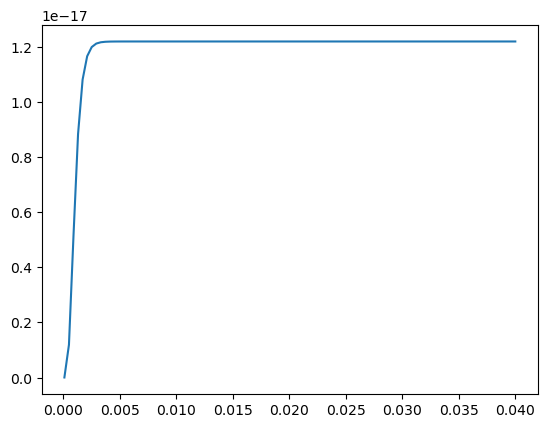

In [2]:
kappa=1.02
# lambda_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0

xi=1.5e6
lambda_0=xi/(3.8e6*60**2)

phi=np.linspace(0.0001,0.04,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  0.999999999999996 , n_s:  0.966668149923885 , P_r: 3.80364765125183
Epsilon:  0.999999999999996 , n_s:  0.966668149923885 , P_r: 3.80364765125183
Epsilon:  0.999999999999996 , n_s:  0.966668149923885 , P_r: 3.80364765125183
Epsilon:  0.999999999999997 , n_s:  0.966668149923891 , P_r: 3.80364766606237
Epsilon:  0.999999999991109 , n_s:  2670.70310311609 , P_r: 12.7363932403841
Epsilon:  0.999999999999989 , n_s:  0.966668114806565 , P_r: 3.73003897574020
Epsilon:  0.999999999999989 , n_s:  0.966668114806572 , P_r: 3.73003899054383
Epsilon:  0.999999999999533 , n_s:  0.966668025353299 , P_r: 3.57696940285128
Epsilon:  0.999999999999534 , n_s:  0.966668025353309 , P_r: 3.57696941763887
Epsilon:  1.00000000000001 , n_s:  0.966667704646842 , P_r: 3.24308745073317
Epsilon:  1.00000000000001 , n_s:  0.966667704646862 , P_r: 3.24308746547615
Epsilon:  0.999999999999999 , n_s:  0.966667435365066 , P_r: 3.08163939796421
Epsilon:  1.00000000000000 , n_s:  0.966667435365097 , P_r: 3.08163

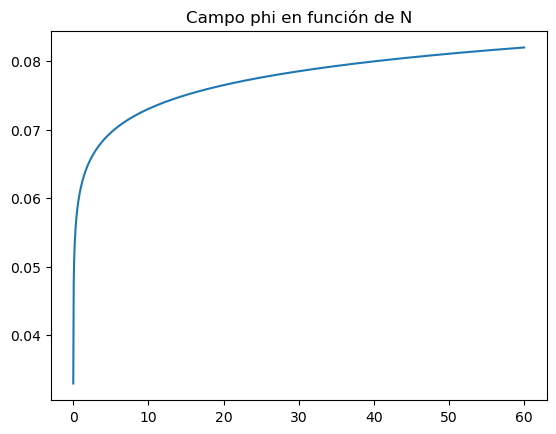

El valor de n_s es  0.966667458296091
El valor de r es  5.55532733133830e-8
La normalización de P_r es 3.09399988291533
El valor de eps(0) es  0.999999999999999
El valor de phi(60) es  0.0819697864682907

Phi_0:  0.032956445702673816 , Kappa:  1.02 , xi:  10000.0
Lambda_0:  7.16865827955297e-07 , b/16/kappa:  1.409313725490196e-06


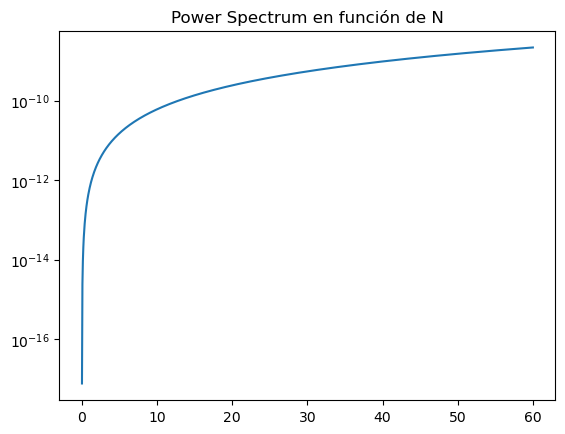

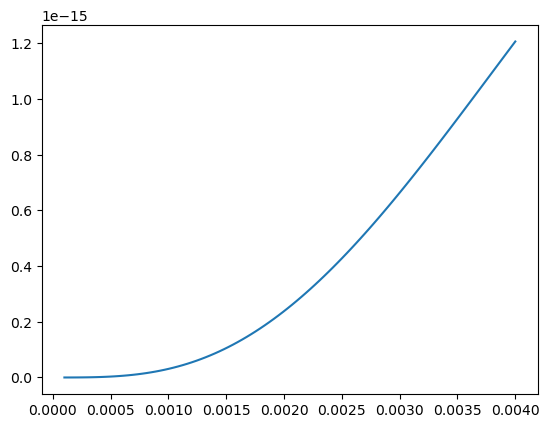

In [3]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1e4
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_1_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  0.999999999999998 , n_s:  0.966667870668493 , P_r: 3.39816653444926
Epsilon:  0.999999999999998 , n_s:  0.966667870668493 , P_r: 3.39816653444926
Epsilon:  0.999999999999998 , n_s:  0.966667870668493 , P_r: 3.39816653444926
Epsilon:  1.00000000000000 , n_s:  0.966667870668498 , P_r: 3.39816654925968
Epsilon:  1.00000000000000 , n_s:  0.966667715392386 , P_r: 3.03552069582082
Epsilon:  1.00000000000000 , n_s:  0.966667715392395 , P_r: 3.03552071059171
Epsilon:  0.999999999997552 , n_s:  0.966667747258858 , P_r: 3.09235384705771
Epsilon:  0.999999999997553 , n_s:  0.966667747258866 , P_r: 3.09235386183575
Epsilon:  0.999999999997651 , n_s:  0.966667748128432 , P_r: 3.09399864612292
Epsilon:  0.999999999997650 , n_s:  0.966667748128439 , P_r: 3.09399866090114
Epsilon:  0.999999999997650 , n_s:  0.966667748129146 , P_r: 3.09400000000084


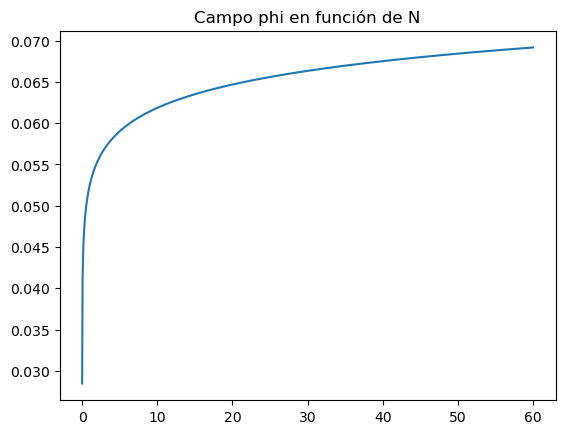

El valor de n_s es  0.966667744864158
El valor de r es  3.70347162173110e-8
La normalización de P_r es 3.09399980409499
El valor de eps(0) es  0.999999999997650
El valor de phi(60) es  0.06916240919742303

Phi_0:  0.028473050229693535 , Kappa:  1.02 , xi:  15000.0
Lambda_0:  1.0797846616411211e-06 , b/16/kappa:  1.409313725490196e-06


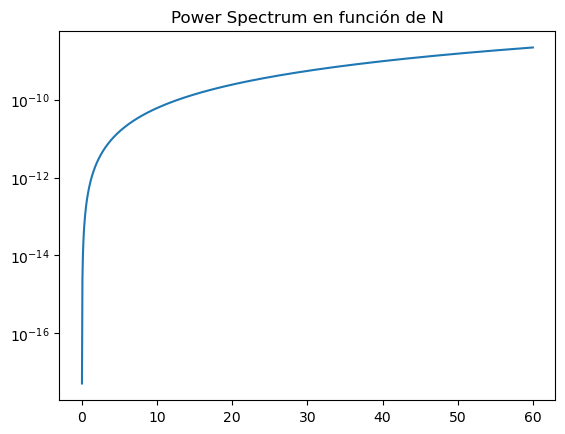

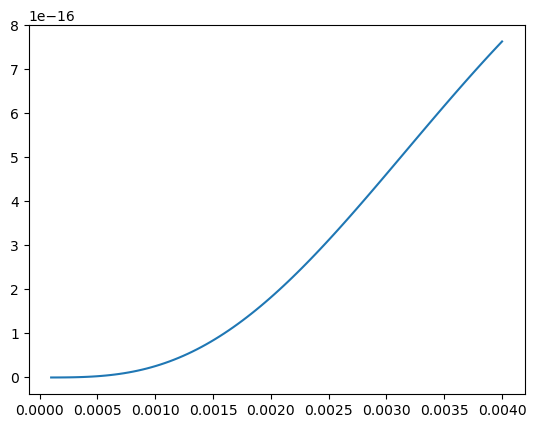

In [4]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1.5e4
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_2_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  0.999999999999999 , n_s:  0.966669822526559 , P_r: -3.10400502488177
Epsilon:  0.999999999999999 , n_s:  0.966669822526559 , P_r: -3.10400502488177
Epsilon:  0.999999999999999 , n_s:  0.966669822526559 , P_r: -3.10400502488177
Epsilon:  1.00000000000000 , n_s:  0.966669822526559 , P_r: -3.10400501007167
Epsilon:  1.00000000000011 , n_s:  0.966669823099736 , P_r: -1.13020147437182
Epsilon:  1.00000000000010 , n_s:  0.966669823099736 , P_r: -1.13020145948330
Epsilon:  1.00000000000000 , n_s:  0.966669823142696 , P_r: -0.128781253301312
Epsilon:  0.999999999999999 , n_s:  0.966669823142696 , P_r: -0.128781238404795
Epsilon:  1.00000000000000 , n_s:  0.966669823152057 , P_r: 0.361418711324638
Epsilon:  1.00000000000000 , n_s:  0.966669823152057 , P_r: 0.361418726222953
Epsilon:  0.999999999999695 , n_s:  0.966669823158454 , P_r: 0.935214736690098
Epsilon:  0.999999999999696 , n_s:  0.966669823158454 , P_r: 0.935214751589661
Epsilon:  0.999999999999986 , n_s:  0.966669823162277 , 

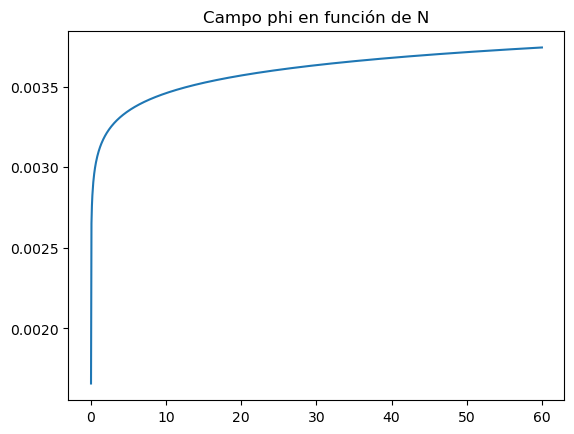

El valor de n_s es  0.966669821612927
El valor de r es  5.55450395427480e-11
La normalización de P_r es 3.09399985221969
El valor de eps(0) es  1.00000000000000
El valor de phi(60) es  0.003743813714367744

Phi_0:  0.0016577842579234585 , Kappa:  1.02 , xi:  10000000.0
Lambda_0:  0.0007257682110536035 , b/16/kappa:  1.409313725490196e-06


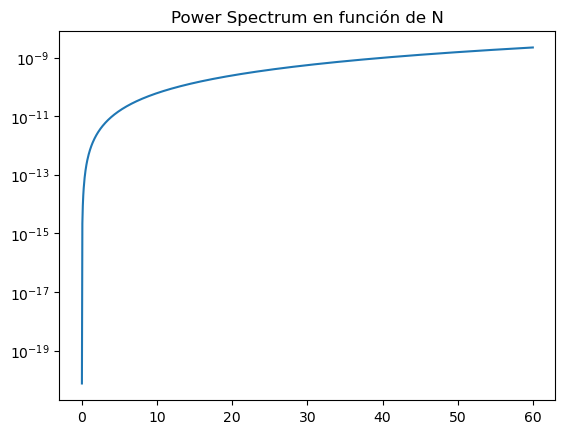

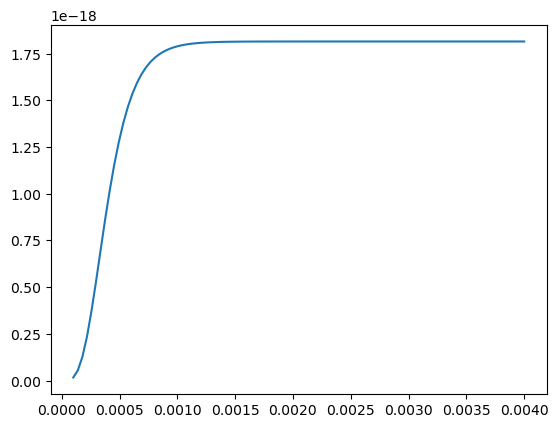

In [5]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1e7
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_3_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  1.00000000000000 , n_s:  0.966666948628360 , P_r: 1.50099249636174
Epsilon:  1.00000000000000 , n_s:  0.966666948628360 , P_r: 1.50099249636174
Epsilon:  1.00000000000000 , n_s:  0.966666948628360 , P_r: 1.50099249636174
Epsilon:  1.00000000000000 , n_s:  0.966666948628361 , P_r: 1.50099251117187
Epsilon:  1.00000000000000 , n_s:  0.966666973744920 , P_r: 2.45381098712798
Epsilon:  0.999999999999999 , n_s:  0.966666973744920 , P_r: 2.45381100199403
Epsilon:  1.00000000000000 , n_s:  0.966666978537668 , P_r: 2.94862253169330
Epsilon:  1.00000000000000 , n_s:  0.966666978537669 , P_r: 2.94862254657307
Epsilon:  1.00000000000314 , n_s:  0.966666979436129 , P_r: 3.08435668122111
Epsilon:  1.00000000000314 , n_s:  0.966666979436129 , P_r: 3.08435669610359
Epsilon:  1.00000000000290 , n_s:  0.966666979494584 , P_r: 3.09395379359375
Epsilon:  1.00000000000290 , n_s:  0.966666979494584 , P_r: 3.09395380847639
Epsilon:  1.00000000000290 , n_s:  0.966666979494864 , P_r: 3.0939999989420

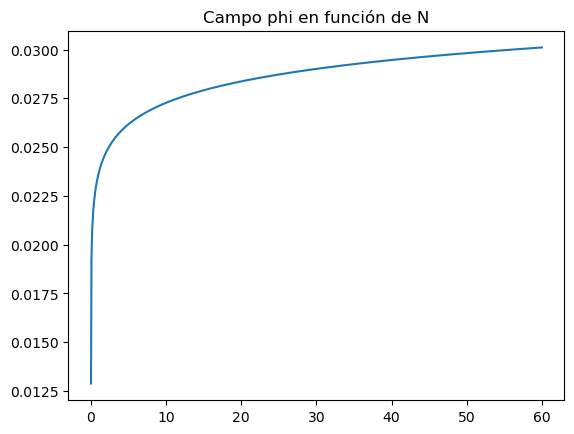

El valor de n_s es  0.966666979475177
El valor de r es  5.55545125000587e-9
La normalización de P_r es 3.09399999776088
El valor de eps(0) es  1.00000000000290
El valor de phi(60) es  0.030106686749930257

Phi_0:  0.012885744572238608 , Kappa:  1.02 , xi:  100000.0
Lambda_0:  7.249992126990545e-06 , b/16/kappa:  1.409313725490196e-06


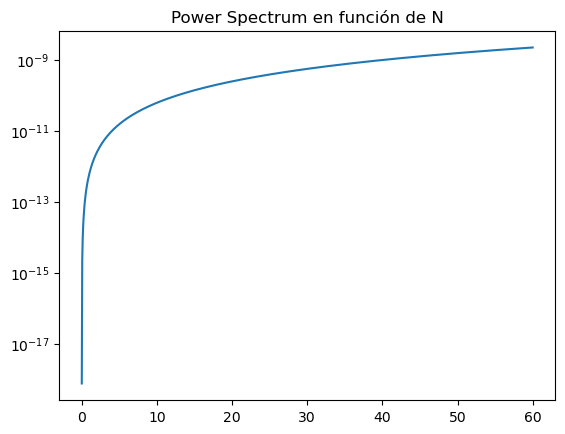

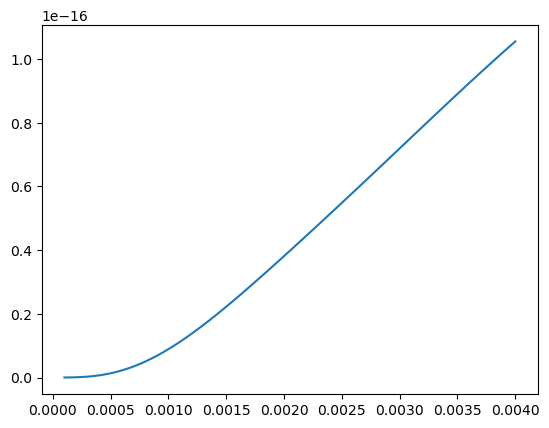

In [6]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1e5
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_4_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  1.00000000000000 , n_s:  0.966667900693384 , P_r: 1.09558458819230
Epsilon:  1.00000000000000 , n_s:  0.966667900693384 , P_r: 1.09558458819230
Epsilon:  1.00000000000000 , n_s:  0.966667900693384 , P_r: 1.09558458819230
Epsilon:  0.999999999999998 , n_s:  0.966667900693384 , P_r: 1.09558460300243
Epsilon:  1.00000000000000 , n_s:  0.966667919426728 , P_r: 2.19366828100769
Epsilon:  1.00000000000000 , n_s:  0.966667919426728 , P_r: 2.19366829587848
Epsilon:  1.00000000000083 , n_s:  0.966667922822148 , P_r: 2.83569673029192
Epsilon:  1.00000000000084 , n_s:  0.966667922822148 , P_r: 2.83569674517711
Epsilon:  1.00000000000013 , n_s:  0.966667923551415 , P_r: 3.06546092168012
Epsilon:  1.00000000000013 , n_s:  0.966667923551415 , P_r: 3.06546093656859
Epsilon:  1.00000000000010 , n_s:  0.966667923628809 , P_r: 3.09360034251529
Epsilon:  1.00000000000010 , n_s:  0.966667923628809 , P_r: 3.09360035740410
Epsilon:  1.00000000000010 , n_s:  0.966667923629891 , P_r: 3.0939999204986

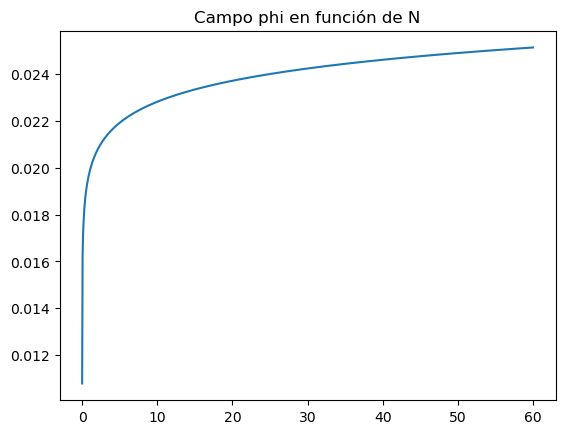

El valor de n_s es  0.966667923645196
El valor de r es  3.70342433411728e-9
La normalización de P_r es 3.09399992141706
El valor de eps(0) es  1.00000000000010
El valor de phi(60) es  0.02511935796153884

Phi_0:  0.010797322838778323 , Kappa:  1.02 , xi:  150000.0
Lambda_0:  1.0878879966355308e-05 , b/16/kappa:  1.409313725490196e-06


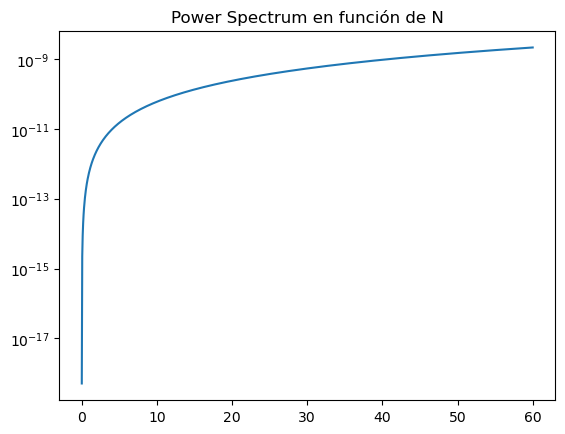

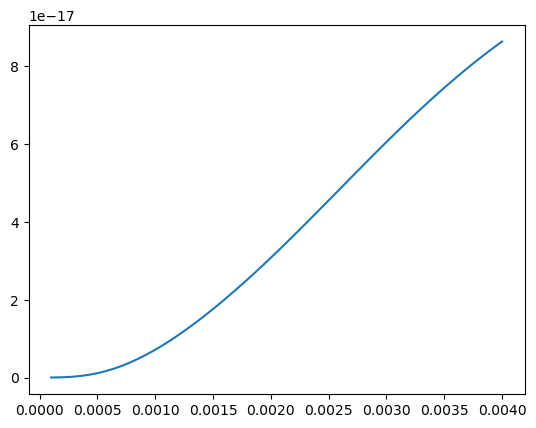

In [7]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1.5e5
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_5_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  0.999999999999999 , n_s:  0.966668267323033 , P_r: -0.801263861623935
Epsilon:  0.999999999999999 , n_s:  0.966668267323033 , P_r: -0.801263861623935
Epsilon:  0.999999999999999 , n_s:  0.966668267323033 , P_r: -0.801263861623935
Epsilon:  1.00000000000000 , n_s:  0.966668267323032 , P_r: -0.801263846817538
Epsilon:  1.00000000000172 , n_s:  0.966668268602090 , P_r: 0.787004748789125
Epsilon:  1.00000000000172 , n_s:  0.966668268602090 , P_r: 0.787004763670940
Epsilon:  0.999999999999999 , n_s:  0.966668268876549 , P_r: 1.73921923713909
Epsilon:  1.00000000000000 , n_s:  0.966668268876549 , P_r: 1.73921925203279
Epsilon:  1.00000000000000 , n_s:  0.966668268945808 , P_r: 2.21800572321133
Epsilon:  1.00000000000000 , n_s:  0.966668268945809 , P_r: 2.21800573810787
Epsilon:  1.00000000000000 , n_s:  0.966668268995422 , P_r: 2.78384808594028
Epsilon:  0.999999999999998 , n_s:  0.966668268995422 , P_r: 2.78384810083882
Epsilon:  1.00000000000078 , n_s:  0.966668269011007 , P_r: 3

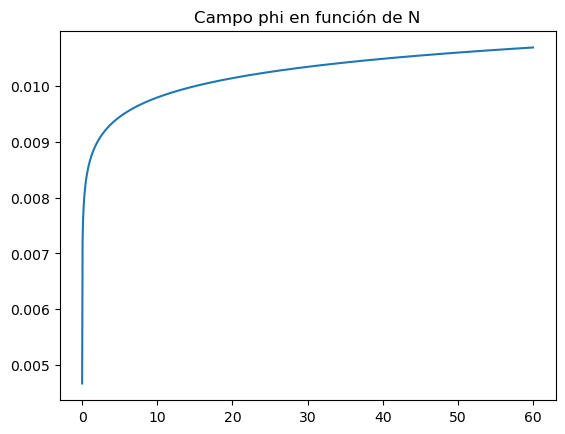

El valor de n_s es  0.966668268591448
El valor de r es  5.55502157213586e-10
La normalización de P_r es 3.09399997470648
El valor de eps(0) es  1.00000000000063
El valor de phi(60) es  0.010689417404397982

Phi_0:  0.004668469160222342 , Kappa:  0.98 , xi:  1000000.0
Lambda_0:  7.257510819855915e-05 , b/16/kappa:  1.4668367346938777e-06


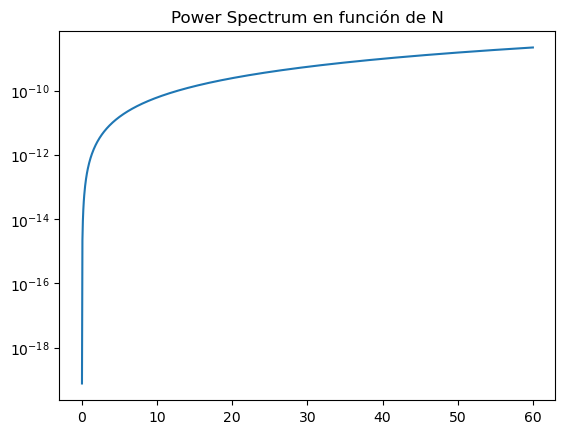

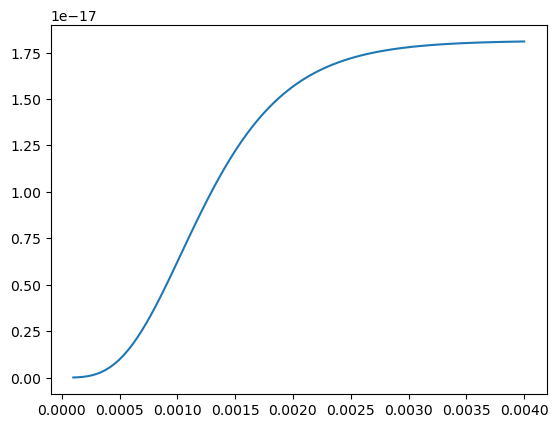

In [8]:
kappa=0.98
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1e6
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_6_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  1.00000000000000 , n_s:  0.966668320751884 , P_r: -1.20697516568231
Epsilon:  1.00000000000000 , n_s:  0.966668320751884 , P_r: -1.20697516568231
Epsilon:  1.00000000000000 , n_s:  0.966668320751884 , P_r: -1.20697516568231
Epsilon:  1.00000000000000 , n_s:  0.966668320751884 , P_r: -1.20697515087220
Epsilon:  1.00000000000133 , n_s:  0.966668324151122 , P_r: 0.460915039391859
Epsilon:  1.00000000000133 , n_s:  0.966668324151122 , P_r: 0.460915054275850
Epsilon:  1.00000000000000 , n_s:  0.966668324510696 , P_r: 1.42512343422496
Epsilon:  1.00000000000000 , n_s:  0.966668324510696 , P_r: 1.42512344911957
Epsilon:  1.00000000000000 , n_s:  0.966668324591664 , P_r: 1.90675611579779
Epsilon:  0.999999999999999 , n_s:  0.966668324591664 , P_r: 1.90675613069489
Epsilon:  0.999999999998132 , n_s:  0.966668324647546 , P_r: 2.47459634451993
Epsilon:  0.999999999998132 , n_s:  0.966668324647546 , P_r: 2.47459635941880
Epsilon:  0.999999999999833 , n_s:  0.966668324675258 , P_r: 2.9566

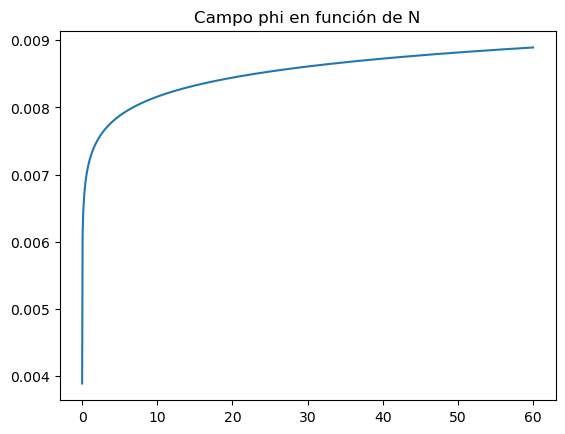

El valor de n_s es  0.966668326416099
El valor de r es  3.70333486993795e-10
La normalización de P_r es 3.09400010342244
El valor de eps(0) es  0.999999999999916
El valor de phi(60) es  0.008891244455902827

Phi_0:  0.003892399982584273 , Kappa:  1.02 , xi:  1500000.0
Lambda_0:  0.0001088673603695046 , b/16/kappa:  1.409313725490196e-06


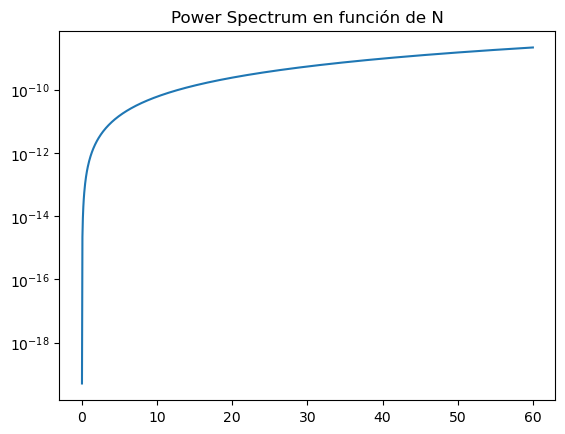

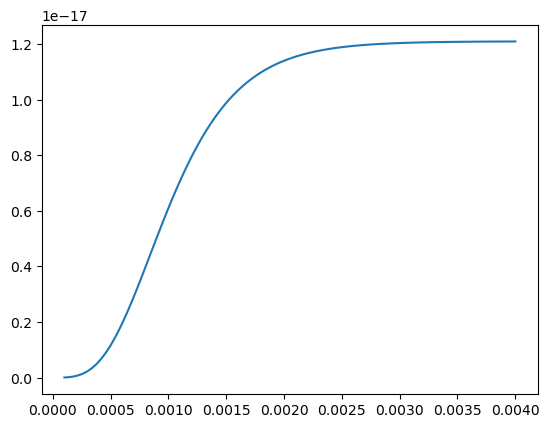

In [9]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1.5e6
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_7_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  0.999999999999999 , n_s:  0.966669822526559 , P_r: -3.10400502488177
Epsilon:  0.999999999999999 , n_s:  0.966669822526559 , P_r: -3.10400502488177
Epsilon:  0.999999999999999 , n_s:  0.966669822526559 , P_r: -3.10400502488177
Epsilon:  1.00000000000000 , n_s:  0.966669822526559 , P_r: -3.10400501007167
Epsilon:  1.00000000000011 , n_s:  0.966669823099736 , P_r: -1.13020147437182
Epsilon:  1.00000000000010 , n_s:  0.966669823099736 , P_r: -1.13020145948330
Epsilon:  1.00000000000000 , n_s:  0.966669823142696 , P_r: -0.128781253301312
Epsilon:  0.999999999999999 , n_s:  0.966669823142696 , P_r: -0.128781238404795
Epsilon:  1.00000000000000 , n_s:  0.966669823152057 , P_r: 0.361418711324638
Epsilon:  1.00000000000000 , n_s:  0.966669823152057 , P_r: 0.361418726222953
Epsilon:  0.999999999999695 , n_s:  0.966669823158454 , P_r: 0.935214736690098
Epsilon:  0.999999999999696 , n_s:  0.966669823158454 , P_r: 0.935214751589661
Epsilon:  0.999999999999986 , n_s:  0.966669823162277 , 

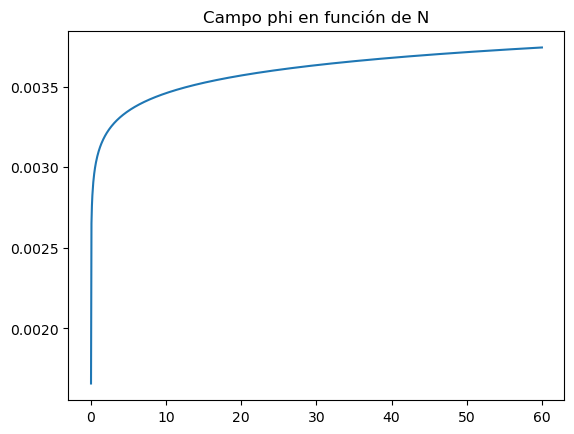

El valor de n_s es  0.966669821612927
El valor de r es  5.55450395427480e-11
La normalización de P_r es 3.09399985221969
El valor de eps(0) es  1.00000000000000
El valor de phi(60) es  0.003743813714367744

Phi_0:  0.0016577842579234585 , Kappa:  1.02 , xi:  10000000.0
Lambda_0:  0.0007257682110536035 , b/16/kappa:  1.409313725490196e-06


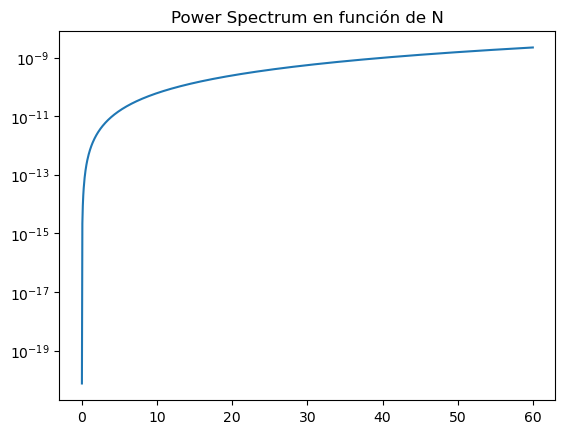

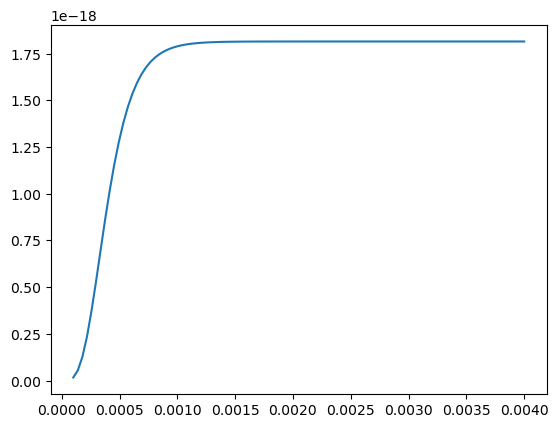

In [10]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1e7
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_8_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  1.00000000000000 , n_s:  0.966659665850932 , P_r: -3.51007949764069
Epsilon:  1.00000000000000 , n_s:  0.966659665850932 , P_r: -3.51007949764069
Epsilon:  1.00000000000000 , n_s:  0.966659665850932 , P_r: -3.51007949764069
Epsilon:  1.00000000000000 , n_s:  0.966659665850932 , P_r: -3.51007948283059
Epsilon:  1.00000000000007 , n_s:  0.966659665719135 , P_r: -1.48139496986364
Epsilon:  1.00000000000007 , n_s:  0.966659665719135 , P_r: -1.48139495497446
Epsilon:  1.00000000000000 , n_s:  0.966659665713176 , P_r: -0.474538679802257
Epsilon:  1.00000000000000 , n_s:  0.966659665713176 , P_r: -0.474538664905482
Epsilon:  1.00000000000000 , n_s:  0.966659665711966 , P_r: 0.0168803808355814
Epsilon:  1.00000000000000 , n_s:  0.966659665711966 , P_r: 0.0168803957340569
Epsilon:  0.999999999999777 , n_s:  0.966659665711159 , P_r: 0.591516897268545
Epsilon:  0.999999999999777 , n_s:  0.966659665711158 , P_r: 0.591516912168178
Epsilon:  0.999999999999989 , n_s:  0.966659665710683 , P_

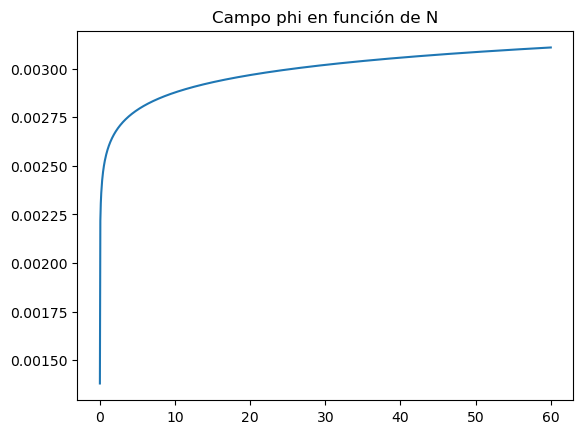

El valor de n_s es  0.966659677081998
El valor de r es  3.70525710656486e-11
La normalización de P_r es 3.09400068205009
El valor de eps(0) es  0.999999999981578
El valor de phi(60) es  0.0031091306531185903

Phi_0:  0.0013797614135358921 , Kappa:  1.02 , xi:  15000000.0
Lambda_0:  0.001089320534029331 , b/16/kappa:  1.409313725490196e-06


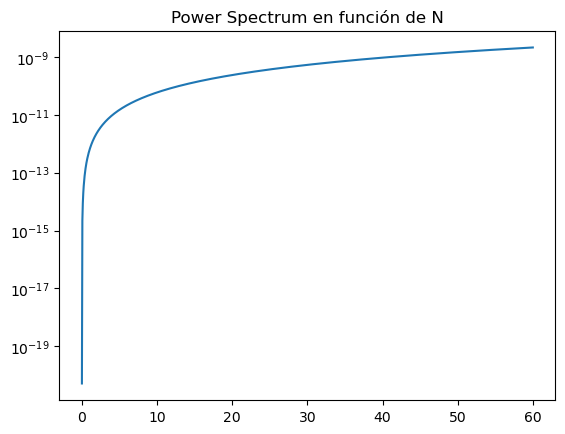

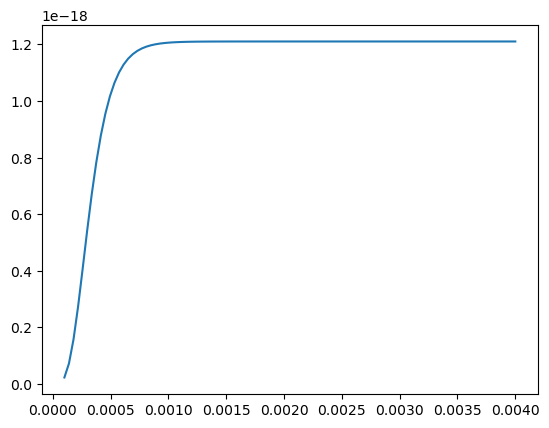

In [11]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1.5e7
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_9_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Epsilon:  0.999999999999999 , n_s:  0.966654160478852 , P_r: -5.40752970695567
Epsilon:  0.999999999999999 , n_s:  0.966654160478852 , P_r: -5.40752970695567
Epsilon:  0.999999999999999 , n_s:  0.966654160478852 , P_r: -5.40752970695567
Epsilon:  0.999999999999999 , n_s:  0.966654160478852 , P_r: -5.40752969214557
Epsilon:  1.00000000000001 , n_s:  0.966654160141511 , P_r: -3.15607711395457
Epsilon:  1.00000000000001 , n_s:  0.966654160141511 , P_r: -3.15607709906298
Epsilon:  1.00000000000000 , n_s:  0.966654160126400 , P_r: -2.13021204457582
Epsilon:  1.00000000000000 , n_s:  0.966654160126399 , P_r: -2.13021202967810
Epsilon:  0.999999999998858 , n_s:  0.966654160123247 , P_r: -1.63459318931325
Epsilon:  0.999999999998855 , n_s:  0.966654160123248 , P_r: -1.63459317441416
Epsilon:  0.999999999999935 , n_s:  0.966654160121122 , P_r: -1.05707437868328
Epsilon:  0.999999999999936 , n_s:  0.966654160121121 , P_r: -1.05707436378330
Epsilon:  0.999999999999995 , n_s:  0.966654160119862 , 

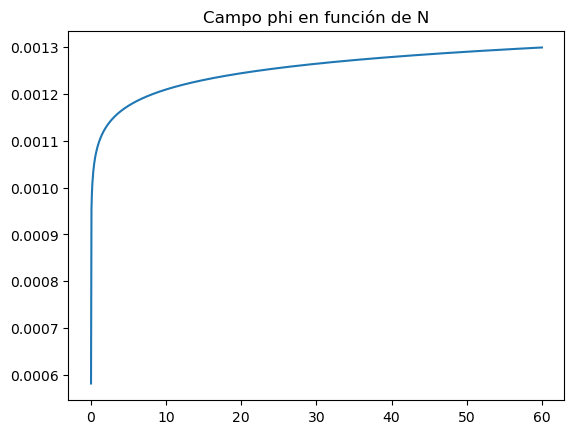

El valor de n_s es  0.966654096032332
El valor de r es  5.55974655687320e-12
La normalización de P_r es 3.09399614257824
El valor de eps(0) es  0.999999999999936
El valor de phi(60) es  0.001299017640630515

Phi_0:  0.00058181620637911 , Kappa:  1.02 , xi:  100000000.0
Lambda_0:  0.007264586560071465 , b/16/kappa:  1.409313725490196e-06


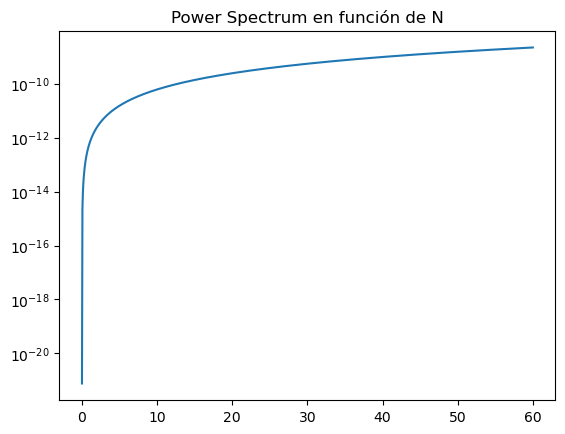

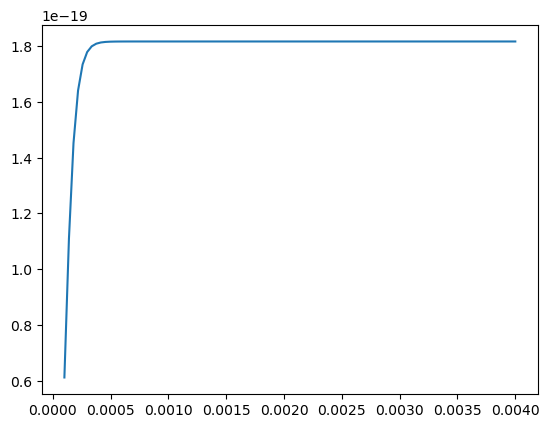

In [12]:
kappa=1.02
lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
xi=1e8
x_0=lambda_0_0

solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

lambda_0=solutions.x[0]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

para=all_parameters(phi_0,kappa,xi,lambda_0)
print()
print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
P_r_10_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

phi=np.linspace(0.0001,0.004,100)
y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

plt.plot(phi,y)
plt.show()

Variando xi desde 1e4 hasta 1e8


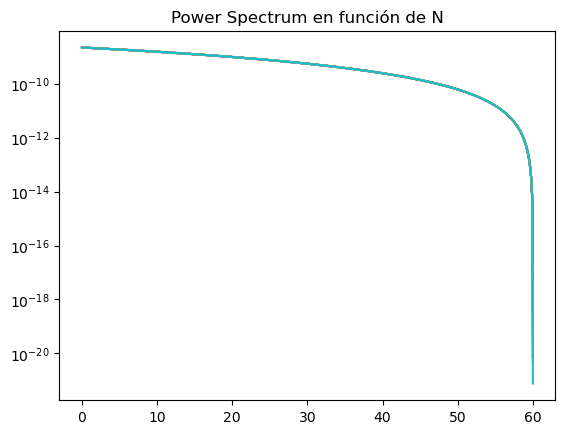

In [21]:
print("Variando xi desde 1e4 hasta 1e8")

N=np.linspace(0,60,1000)
plt.plot(N,P_r_1_60)
plt.plot(N,P_r_2_60)
plt.plot(N,P_r_3_60)
plt.plot(N,P_r_4_60)
plt.plot(N,P_r_5_60)
plt.plot(N,P_r_6_60)
plt.plot(N,P_r_7_60)
plt.plot(N,P_r_8_60)
plt.plot(N,P_r_9_60)
plt.plot(N,P_r_10_60)
plt.title("Power Spectrum en función de N")
plt.yscale("log")
plt.show()

In [14]:
# kappa=1.02
# lambda_0_0=b/16/0.98
# xi=3.8e6*60**2*lambda_0_0*2
# x_0=lambda_0_0

# solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,xi))

# lambda_0=solutions.x[0]

# phi_0=correct_phi_0_try(kappa,xi,lambda_0)

# para=all_parameters(phi_0,kappa,xi,lambda_0)
# print()
# print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
# print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
# # P_r_1_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

In [15]:
# kappa=1.02
# lambda_0=b/16/0.98
# # lambda_0=2.9041488143593386e-06
# xi=3.8e6*60**2*lambda_0

# phi=np.linspace(0.0001,0.05,100)
# y=(lambda_0+b*np.log(np.tanh(np.sqrt(xi)*phi)/kappa)**2)*np.tanh(np.sqrt(xi)*phi)**4/4/xi**2

# plt.plot(phi,y)
# plt.show()

In [16]:
# kappa=1.02
# xi=np.linspace(0.5,2,100)
# lambda_0_0=b/16/0.98
# x_0=lambda_0_0

# n_s_plot_1_08=[]
# r_plot_1_08=[]

# for i in range(len(xi)):
#     solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa,3.8e6*60**2*lambda_0*xi[i]))
#     lambda_0=solutions.x[0]

#     phi_0=correct_phi_0_try(kappa,3.8e6*60**2*lambda_0*xi[i],lambda_0)
    
#     para=all_parameters(phi_0,kappa,3.8e6*60**2*lambda_0*xi[i],lambda_0)
    
#     n_s_plot_1_08.append(para[1])
#     r_plot_1_08.append(para[2])

In [17]:
# plt.plot(n_s_plot_1_08,r_plot_1_08)